In [1]:
%load_ext autoreload
%autoreload 2

## Imports and flags

In [2]:
from envs.env import *
import pandas as pd
from config import settings
import pickle
from constants import MAB_FEATURE_NAMES

RESTART_data = True # restart prepare training data
negative_sampling_ratio = 10
gamma = 0.25 # (self.gamma * 1 + (1-self.gamma) * actual_reward)
time_split_date = '2024-12-20' # Validation split, if not put None
RESTART = False # restart Curator Network training
RESTART_reward = False

## Open Data

In [3]:
catalog_df = pd.read_parquet("data/whatson_catalog_df.parquet")
historical_data_df = pd.read_pickle("data/historical_data_df.pkl")
with open(settings.aud_model_dir/"rf_model.pkl", "rb") as f:    # load frozen viewership model
    audience_model = pickle.load(f)

In [4]:
historical_data_df

,title,date,content_class_key,channel,duration_min,hour,day,weekday,is_weekend,month,rt_m,tmdb_id,season,processed_title,missing_tmdb_id,catalog_id
22,Cher Noël,2024-01-01,72,RTS 1,86.116667,14,1,0,False,1,22.1,744941.0,winter,Cher Noël,False,744941
24,James Bond: Jamais plus jamais,2024-01-01,71,RTS 1,126.333333,15,1,0,False,1,44.0,36670.0,winter,Jamais plus jamais,False,36670
32,Super-héros malgré lui,2024-01-01,71,RTS 1,77.350000,20,1,0,False,1,75.4,746333.0,winter,Super-héros malgré lui,False,746333
33,Qu'est-ce qu'on a fait au Bon Dieu ?,2024-01-01,71,RTS 1,93.716667,21,1,0,False,1,44.9,262391.0,winter,Qu'est-ce qu'on a fait au Bon Dieu ?,False,262391
34,Séduis-moi si tu peux,2024-01-01,71,RTS 1,112.800000,23,1,0,False,1,14.5,459992.0,winter,Séduis-moi si tu peux !,False,459992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85478,Fiston,2025-02-21,71,RTS 2,84.783333,21,21,4,False,2,15.5,252607.0,winter,Fiston,False,252607
85573,VOYAGE A TOKYO,2025-02-21,AAF,France 3,45.683333,25,21,4,False,2,0.5,18148.0,winter,Voyage à Tokyo,False,18148
85653,Adorables,2025-02-22,71,RTS 1,89.983333,20,22,5,True,2,50.8,701437.0,winter,Adorables,False,701437
85654,Illusions perdues,2025-02-22,71,RTS 1,146.483333,22,22,5,True,2,11.3,43799.0,winter,Illusions perdues,False,43799


In [5]:
#historical_data_df['catalog_id'] = historical_data_df['catalog_id'].astype('Int64').astype(str)

In [6]:
historical_data_df['catalog_id'].value_counts()

catalog_id
-1        17
796648     6
916373     4
881770     4
206647     3
          ..
395993     1
868522     1
15120      1
11812      1
43799      1
Name: count, Length: 1338, dtype: int64

In [7]:
show_cols = ['date_diff_1', 'date_rediff_1', 'date_rediff_2', 'date_rediff_3', 'date_rediff_4']
air_date = datetime.today()
catalog_df.loc[0, show_cols].lt(air_date).sum()

2

## Prepare Environment

In [8]:
env = TVProgrammingEnvironment(movie_catalog=catalog_df,
                         historical_df= historical_data_df,
                         audience_model=audience_model,
                         reward_weights= None)

Setting up CompetitorDataManager...
Setting up Scalers...
Setting up RewardCalculator...
Setting up ContextualThompsonSampler...
Setting up CuratorNetwork...


In [9]:
from IL_training import *

hist_data_processor = HistoricalDataProcessor(environment=env, gamma=gamma)

## Prepare Training Data

competitive_showings = [771077, 398920, 398920, 770554, 594691, 455446, 658905, 745589, 838916, 546554, 925102, 880728, 1149095, 762504, 446354, 768127]

In [10]:
if RESTART_data:
    training_data, all_rewards, movies_not_found = hist_data_processor.prepare_training_data(channel_name='RTS 1', negative_sampling_ratio=negative_sampling_ratio, 
                                                                                             time_split_date=time_split_date)

Processing historical programming data...
Found 973 programming decisions for RTS 1


Processing rows: 100%|██████████| 973/973 [08:31<00:00,  1.90it/s]


Created 973 positive samples


In [11]:
import pickle
from pathlib import Path

TRAINING_PATH = Path("data/IL_data/training_data.pkl")
REWARDS_PATH = Path("data/IL_data/all_rewards.pkl")
MISSING_PATH = Path("data/IL_data/movies_not_found.pkl")

if RESTART_data:
    TRAINING_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(TRAINING_PATH, "wb") as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(REWARDS_PATH, "wb") as f:
        pickle.dump(all_rewards, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(MISSING_PATH, "wb") as f:
        pickle.dump(movies_not_found, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(TRAINING_PATH, "rb") as f:
        training_data = pickle.load(f)

    with open(REWARDS_PATH, "rb") as f:
            all_rewards = pickle.load(f)

    with open(MISSING_PATH, "rb") as f:
            movies_not_found = pickle.load(f)


In [15]:
env.movie_catalog['tmdb_id'] = env.movie_catalog['tmdb_id'].astype('Int64')

In [22]:
env.movie_catalog['tmdb_id']

catalog_id
220             220
12155         12155
XF_000_0       <NA>
11806         11806
279332       279332
             ...   
1075329     1075329
1371348     1371348
942578       942578
883369       883369
1025208     1025208
Name: tmdb_id, Length: 9745, dtype: Int64

In [27]:
import api.tmdb
from tqdm.auto import tqdm
tqdm.pandas()
env.movie_catalog['poster_path'] = env.movie_catalog['tmdb_id'].progress_apply(lambda mid: api.tmdb.get_movie_poster_path(mid, width=200))

  0%|          | 0/9745 [00:00<?, ?it/s]

In [28]:
env.movie_catalog['poster_path']

catalog_id
220         http://image.tmdb.org/t/p/w200/poster_path
12155       http://image.tmdb.org/t/p/w200/poster_path
XF_000_0                                          None
11806       http://image.tmdb.org/t/p/w200/poster_path
279332      http://image.tmdb.org/t/p/w200/poster_path
                               ...                    
1075329     http://image.tmdb.org/t/p/w200/poster_path
1371348     http://image.tmdb.org/t/p/w200/poster_path
942578      http://image.tmdb.org/t/p/w200/poster_path
883369      http://image.tmdb.org/t/p/w200/poster_path
1025208     http://image.tmdb.org/t/p/w200/poster_path
Name: poster_path, Length: 9745, dtype: object

In [33]:
catalog =env.movie_catalog.reset_index()

In [35]:
catalog

,catalog_id,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,...,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown,poster_path
0,220,A l'est d'eden,"James Dean, Julie Harris, Raymond Massey, Rich...",False,0.0,A l'est d'éden,1.0,71,1995-05-26,1998-12-24,...,220,1.0,0.0,7.600,True,False,True,70,0,http://image.tmdb.org/t/p/w200/poster_path
1,12155,Alice au pays des merveilles,None,False,2.0,Alice au pays des merveilles,0.0,71,NaT,NaT,...,12155,2.0,0.0,6.635,True,False,True,15,0,http://image.tmdb.org/t/p/w200/poster_path
2,XF_000_0,Rocket a monte carlo,None,False,3.0,Amicalement votre,0.0,71,NaT,NaT,...,<NA>,3.0,0.0,0.000,True,True,True,125,0,None
3,11806,Beethoven,"Charles Grodin, Bonnie Hunt, Dean Jones, Tom N...",False,3.0,Beethoven,0.0,71,NaT,NaT,...,11806,3.0,0.0,5.830,True,False,True,33,0,http://image.tmdb.org/t/p/w200/poster_path
4,279332,Bonne fete maman,None,False,2.0,Bonne fête maman,0.0,71,NaT,NaT,...,279332,2.0,0.0,5.900,True,False,True,11,0,http://image.tmdb.org/t/p/w200/poster_path
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9740,1075329,Une rose pour sa tombe : L'histoire vraie de C...,,False,NaN,NaN,NaN,72,NaT,NaT,...,1075329,NaN,NaN,6.567,True,False,True,2,1,http://image.tmdb.org/t/p/w200/poster_path
9741,1371348,Haute saison,,False,NaN,NaN,NaN,72,NaT,NaT,...,1371348,NaN,NaN,5.000,True,False,True,0,1,http://image.tmdb.org/t/p/w200/poster_path
9742,942578,La prof est amoureuse,,False,NaN,NaN,NaN,72,NaT,NaT,...,942578,NaN,NaN,6.800,True,False,True,3,1,http://image.tmdb.org/t/p/w200/poster_path
9743,883369,Romance avec une star,,False,NaN,NaN,NaN,72,NaT,NaT,...,883369,NaN,NaN,5.700,True,False,True,3,1,http://image.tmdb.org/t/p/w200/poster_path


In [34]:
# Save processed movie catalog with training data
catalog_name = 'whatson_data_with_training_data'
catalog.to_parquet('data/' + catalog_name + '.parquet')
catalog.to_csv(f"data/{catalog_name}.csv", index=True)

In [12]:
df = env.movie_catalog.copy()
df[df.index.map(lambda x: isinstance(x, float))]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,start_rights,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown
catalog_id,,,,,,,,,,,,,,,,,,,,,


## Visualize Reward Distributions

In [13]:
all_data_reward_targets = np.concatenate((training_data['train']['reward_targets'], training_data['val']['reward_targets']))
np.median(all_data_reward_targets)

0.4064026012610432

In [14]:
reward_audience = [d['audience'] for d in all_rewards]
reward_competition = [d['competition'] for d in all_rewards]
reward_diversity = [d['diversity'] for d in all_rewards]
reward_novelty = [d['novelty'] for d in all_rewards]
reward_rights = [d['rights'] for d in all_rewards]

In [15]:
def show_specs(signal):
    minimum = np.min(signal)
    maximum = np.max(signal)
    median  = np.median(signal)
    mean    = np.mean(signal)
    q1      = np.percentile(signal, 25)
    q3      = np.percentile(signal, 75)
    iqr     = q3 - q1

    print(f"Min:    {minimum}")
    print(f"Q1:     {q1}")
    print(f"Median: {median}")
    print(f"Q3:     {q3}")
    print(f"Max:    {maximum}")
    print(f"IQR:    {iqr}")
    print(f"Mean:   {mean}")

In [16]:
print('------Total Rewards----------')
show_specs(all_data_reward_targets)

------Total Rewards----------
Min:    0.09621764454937945
Q1:     0.3240881818415307
Median: 0.4064026012610432
Q3:     0.4786800722267396
Max:    0.8327195937625145
IQR:    0.15459189038520887
Mean:   0.40817609233318486


In [17]:
env.movie_catalog[['title', 'times_shown', 'available_num_diff', 'consumed_num_diff', 'date_diff_1',
                   'date_last_diff', 'date_rediff_1', 'date_rediff_2', 'date_rediff_3', 'date_rediff_4',]]

,title,times_shown,available_num_diff,consumed_num_diff,date_diff_1,date_last_diff,date_rediff_1,date_rediff_2,date_rediff_3,date_rediff_4
catalog_id,,,,,,,,,,
220,A l'est d'eden,0,0.0,1.0,1995-05-26,1998-12-24,1998-12-24,NaT,NaT,NaT
12155,Alice au pays des merveilles,0,2.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
XF_000_0,Rocket a monte carlo,0,3.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
11806,Beethoven,0,3.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
279332,Bonne fete maman,0,2.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
XF_000_460,Séparation dangereuse,0,1.0,1.0,1999-10-08,2002-03-23,2002-03-23,NaT,NaT,NaT
XF_000_461,La vie d'un basketteur hors du commun,0,1.0,1.0,2002-03-17,2002-03-17,NaT,NaT,NaT,NaT
733369,De gré ou de force,0,1.0,1.0,1999-03-19,2001-12-08,2001-12-08,NaT,NaT,NaT


In [18]:
a = env.movie_catalog.copy()
a[
    (a['times_shown'] > 1)
]#[['title', 'times_shown', 'available_num_diff', 'consumed_num_diff', 'date_diff_1', 'date_last_diff', 'date_rediff_1', 'date_rediff_2', 'date_rediff_3', 'date_rediff_4',]]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,start_rights,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown
catalog_id,,,,,,,,,,,,,,,,,,,,,


In [19]:
print('------Audience----------')
show_specs(reward_audience)
print('\n------Competition----------')
#show_specs([x for x in reward_competition if x > 0])
show_specs(reward_competition)
print('\n------Diversity----------')
show_specs(reward_diversity)
print('\n------Novelty----------')
show_specs(reward_novelty)
print('\n------Rights----------')
show_specs(reward_rights)

------Audience----------
Min:    0.03003003003003003
Q1:     0.31431431431431434
Median: 0.5965965965965966
Q3:     0.8023023023023024
Max:    1.0
IQR:    0.48798798798798804
Mean:   0.5668875418610971

------Competition----------
Min:    0.0
Q1:     0.0
Median: 0.0
Q3:     0.0
Max:    0.8032653298563167
IQR:    0.0
Mean:   0.010965562462613748

------Diversity----------
Min:    0.3
Q1:     0.6387517940319926
Median: 0.7310791011229884
Q3:     0.8058781154222265
Max:    1.0
IQR:    0.16712632139023398
Mean:   0.7212474688122039

------Novelty----------
Min:    0.004794520547945269
Q1:     1.0
Median: 1.0
Q3:     1.0
Max:    1.0
IQR:    0.0
Mean:   0.9554993222998543

------Rights----------
Min:    0.0
Q1:     0.0
Median: 0.1
Q3:     0.1
Max:    1.0
IQR:    0.1
Mean:   0.14871531346351494


## Training

In [20]:
import torch

context_np = np.concatenate((training_data['train']['context_features'], training_data['val']['context_features']))  # numpy array
movie_np = np.concatenate((training_data['train']['movie_features'], training_data['val']['movie_features']))      # numpy array

# Convert to tensors
context_tensor = torch.from_numpy(context_np)
movie_tensor = torch.from_numpy(movie_np)

# Check for NaNs
print("Context NaNs:", torch.isnan(context_tensor).any().item())
print("Movie NaNs:", torch.isnan(movie_tensor).any().item())


Context NaNs: False
Movie NaNs: False


In [21]:
if RESTART:
    # Initialize trainer
    trainer = NetworkTrainer()
    # Train Curator Network
    curator_model = trainer.train_curator_network(
        training_data=training_data['train'],
        validation_data=training_data['val'],
        epochs=1000,
        batch_size=256,
        learning_rate=0.001,
        early_stopping_patience = 100
    )

Training Curator Network...
[Reward] Epoch 000: Train Loss=0.6062, Val Loss=0.4578 (no_improve=0)
[Reward] Epoch 001: Train Loss=0.4369, Val Loss=0.3647 (no_improve=0)
[Reward] Epoch 010: Train Loss=0.2572, Val Loss=0.3376 (no_improve=4)
[Reward] Epoch 020: Train Loss=0.1877, Val Loss=0.3638 (no_improve=8)
[Reward] Epoch 030: Train Loss=0.1613, Val Loss=0.4373 (no_improve=18)
[Reward] Epoch 040: Train Loss=0.1320, Val Loss=0.4452 (no_improve=28)
[Reward] Epoch 050: Train Loss=0.1272, Val Loss=0.5386 (no_improve=38)
[Reward] Epoch 060: Train Loss=0.1175, Val Loss=0.5240 (no_improve=48)
[Reward] Epoch 070: Train Loss=0.1186, Val Loss=0.5095 (no_improve=58)
[Reward] Epoch 080: Train Loss=0.1163, Val Loss=0.5063 (no_improve=68)
[Reward] Epoch 090: Train Loss=0.1180, Val Loss=0.5039 (no_improve=78)
[Reward] Epoch 100: Train Loss=0.1081, Val Loss=0.5165 (no_improve=88)
[Reward] Epoch 110: Train Loss=0.1085, Val Loss=0.5140 (no_improve=98)
[Reward] Early stopping triggered at epoch 112. Best 

In [22]:
if RESTART_reward:
    # Train Reward Model
    reward_model = trainer.train_reward_model(
        training_data=training_data,
        epochs=1000,
        batch_size=256,
        learning_rate=0.001
    )

## Save models

In [23]:
movie_np.shape

(10703, 24)

In [24]:
context_features = context_np
#movie_features = np.squeeze(training_data['movie_features'])
movie_features = movie_np
context_dim = context_features.shape[1]
movie_dim = movie_features.shape[1]

In [25]:
movie_features.shape

(10703, 24)

In [26]:
if RESTART:
    # Save models
    torch.save(curator_model.state_dict(), 'models/curator_model.pth')

else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Initialize model
    curator_model = CuratorNetwork(context_dim, movie_dim).to(device)
    curator_model.load_state_dict(torch.load('models/curator_model.pth'))


if RESTART_reward:
    torch.save(reward_model.state_dict(), 'models/reward_model.pth')

In [27]:
print(context_dim)
print(movie_dim)

16
24


## Prepare training Data for TS

In [28]:
aud_reward_features = np.array(reward_audience).reshape(-1,1)
comp_reward_features = np.array(reward_competition).reshape(-1,1)
div_reward_features = np.array(reward_diversity).reshape(-1,1)
nov_reward_features = np.array(reward_novelty).reshape(-1,1)
rights_reward_features = np.array(reward_rights).reshape(-1,1)

In [29]:
with torch.no_grad():  # no grad for inference
                selection_prob = torch.Tensor.numpy(curator_model(context_tensor, movie_tensor))

In [30]:
selection_prob = np.expand_dims(selection_prob, axis = 1)

In [31]:
#X_hist = np.concatenate((movie_features, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)
X_hist = np.concatenate((selection_prob, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)

all_feature_names = []
#_, movie_features = env.get_movie_features('589972', return_features=True)
#movie_feature_names= movie_features.columns
#all_feature_names.extend(movie_feature_names)
all_feature_names.extend(['curator_select_prob', 'reward_audience', 'reward_competition', 'reward_diversity', 'reward_novelty','reward_rights'])

In [104]:
all_feature_names

['curator_select_prob',
 'reward_audience',
 'reward_competition',
 'reward_diversity',
 'reward_novelty',
 'reward_rights']

In [32]:
CT_hist = np.concatenate((training_data['train']['curator_targets'], training_data['val']['curator_targets']))
R_hist = np.concatenate((training_data['train']['reward_targets'], training_data['val']['reward_targets'])) # Use pseudo-rewards to nudge the Bayesain model in a desired direction
#R_hist = training_data['curator_targets'] # Use pseudo-rewards to nudge the Bayesain model in a desired direction
print(X_hist.shape)
print(R_hist.shape)

(10703, 6)
(10703,)


In [33]:
R_hist.mean()

0.40817609233318486

In [34]:
m = 0
jump = negative_sampling_ratio + 1
for j in range(900):
    #print(X_hist[j*11][0])#, CT_hist[j*11])
    if X_hist[j*jump][0] < 0.5:
     m+= 1
m

104

In [35]:
X_hist.shape

(10703, 6)

## Contextual-weighted Thompson Sampling

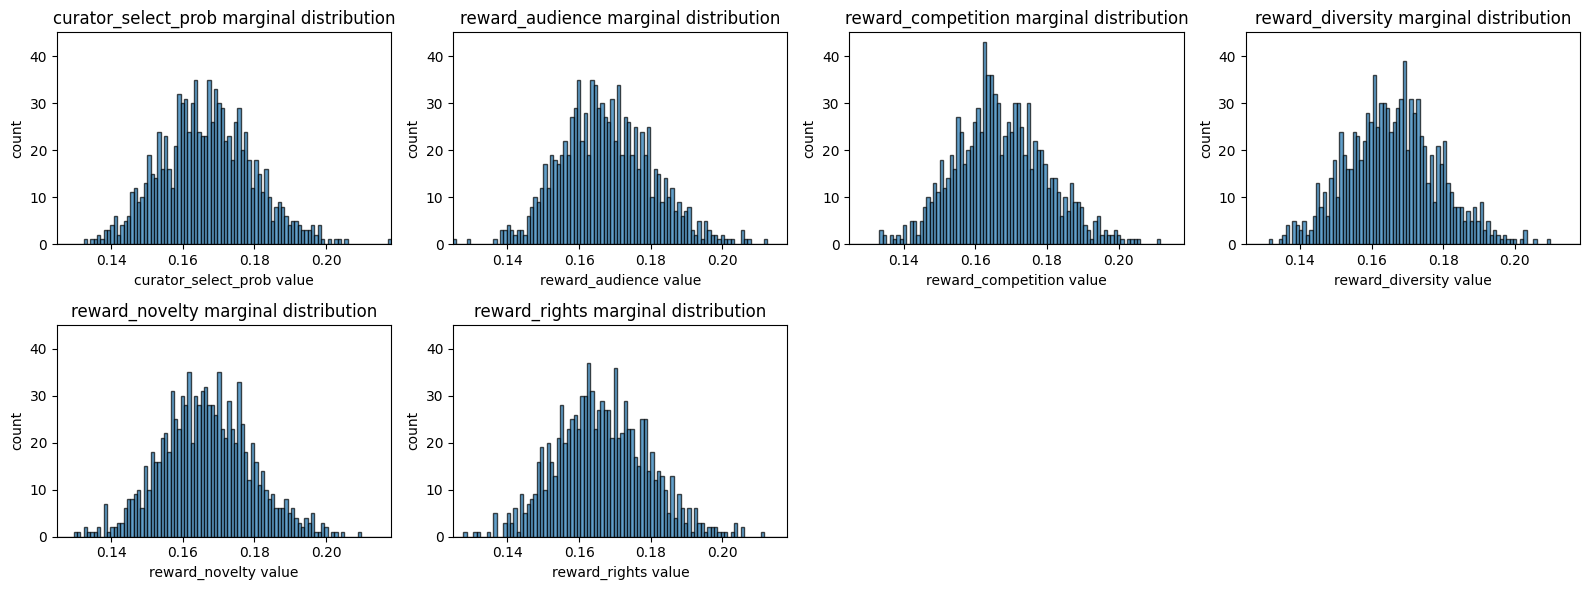

In [72]:
from contextual_thompson import ContextualThompsonSampler, sigmoid
from contextual_ts_testing import *

cts = ContextualThompsonSampler(num_signals=X_hist.shape[1], context_dim=context_features.shape[1], lr = 1e-3, max_grad_norm=0.5, ema_decay=1-1e-3, expl_scale=0.001, h0=1e-1)
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

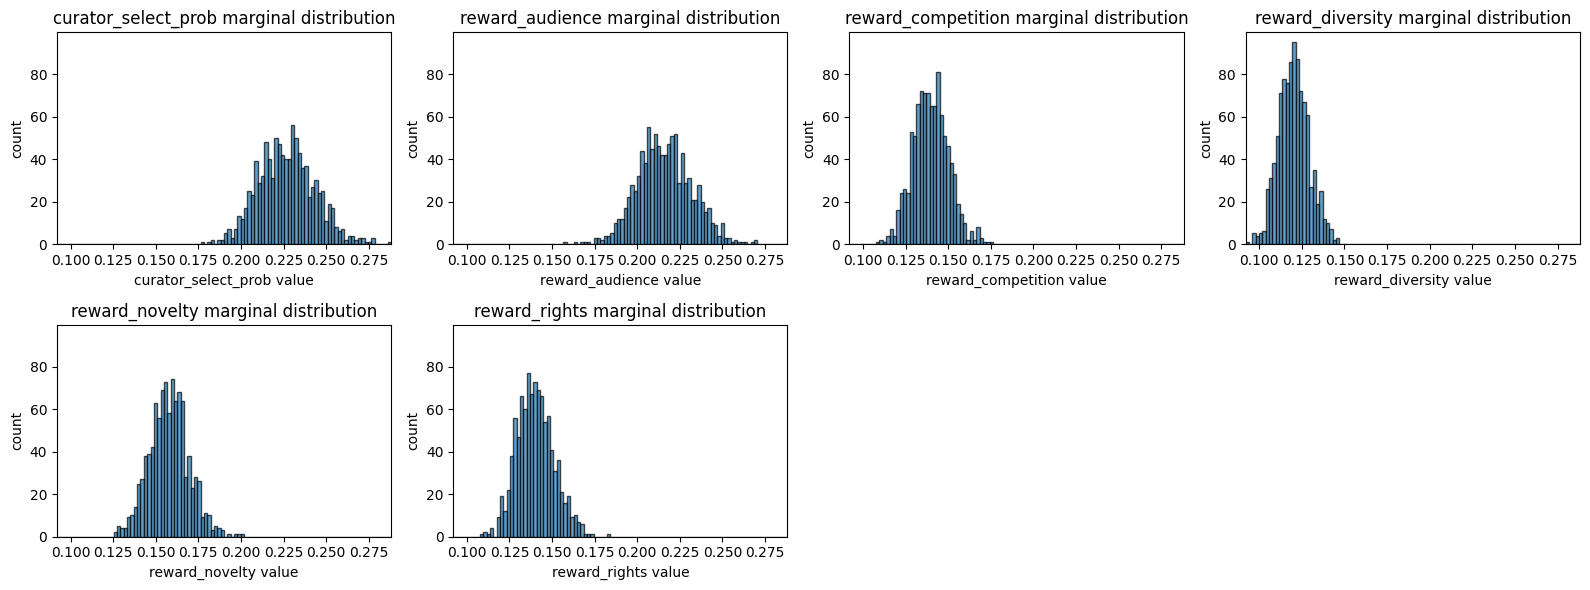

Mean param std: 0.09999999999999999


In [73]:
w_target = np.zeros(X_hist.shape[1]) / X_hist.shape[1]
w_target = [45, 40, 15, 10, 20, 15] 
cts.set_uniform_target_weights(w_target) # Normalizes the sum of weights to be one
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()
param_std = np.sqrt(cts.expl_scale / cts.h_U)      # same shape as U
print("Mean param std:", param_std.mean())

cts.warm_start(context_features, X_hist, R_hist, lr=1e-5)
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

In [74]:
n = 100
context_features_subarrays = np.array_split(context_features, n, axis = 0)
X_hist_subarrays = np.array_split(X_hist, n, axis = 0)
R_hist_subarrays = np.array_split(R_hist, n, axis = 0)


In [75]:
i = 0

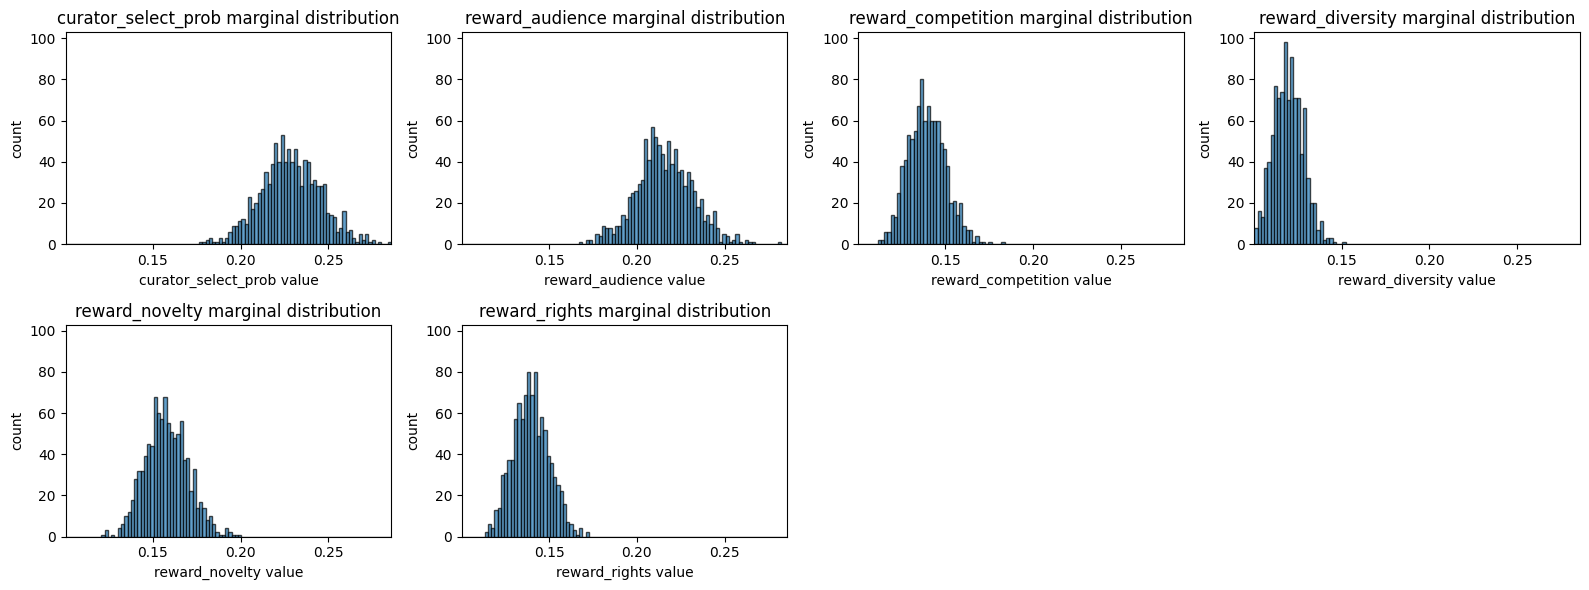

hyperparams: ema_decay = 0.9999
grad_U: -0.002724398068971673, grad_b: -0.19675990943290136
hyperparams: ema_decay = 0.9999
grad_U: 0.004598254459766788, grad_b: -0.1611654871839878
hyperparams: ema_decay = 0.9999
grad_U: 0.00465250807292397, grad_b: -0.16087594889097184
hyperparams: ema_decay = 0.9999
grad_U: 0.004327860090349677, grad_b: -0.16260721910870946
hyperparams: ema_decay = 0.9999
grad_U: 0.005059515681031147, grad_b: -0.1587048702692687
hyperparams: ema_decay = 0.9999
grad_U: 0.0028386069674668844, grad_b: -0.1705495310526575
hyperparams: ema_decay = 0.9999
grad_U: 0.00488104142334617, grad_b: -0.1596563615991998
hyperparams: ema_decay = 0.9999
grad_U: 0.004713904730104175, grad_b: -0.16054757160790792
hyperparams: ema_decay = 0.9999
grad_U: 0.002777446041796217, grad_b: -0.17087516559048685
hyperparams: ema_decay = 0.9999
grad_U: 0.0030003350555133632, grad_b: -0.16968623849578424
hyperparams: ema_decay = 0.9999
grad_U: 0.004464435449293946, grad_b: -0.16187751737426234
hy

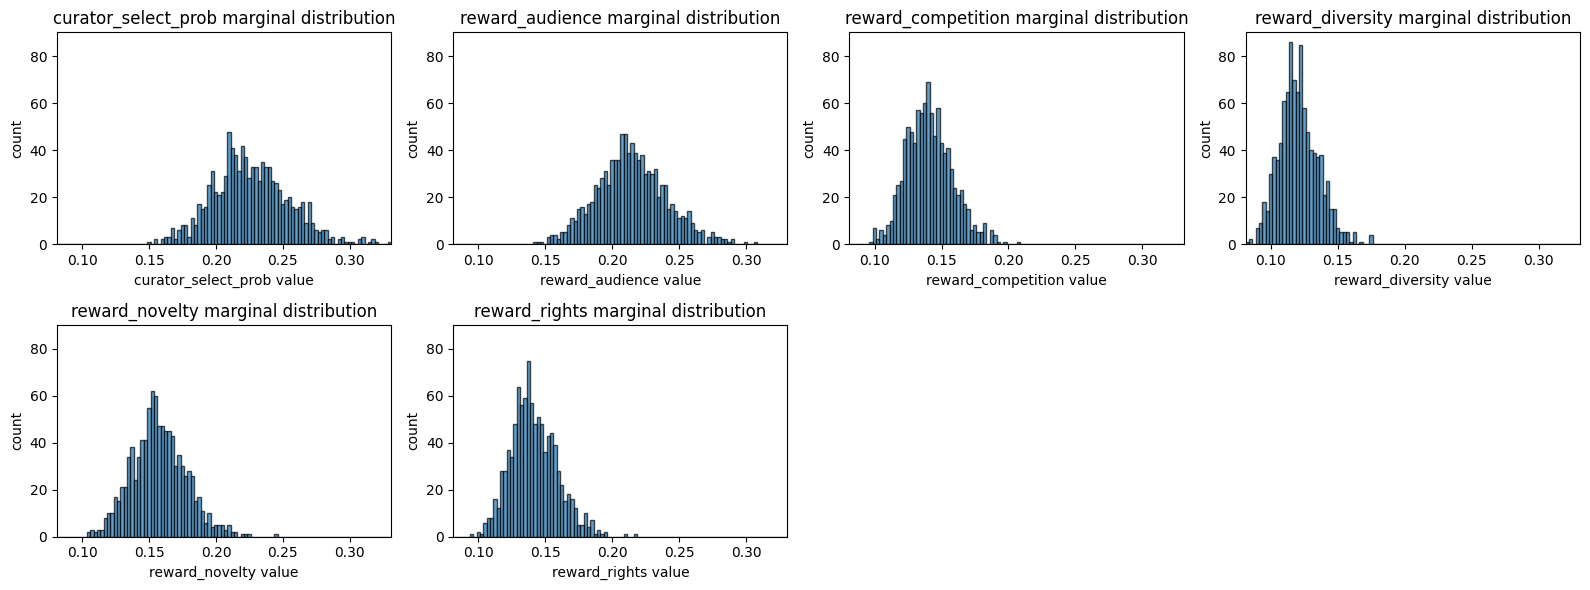

In [76]:
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()
for i in range(n):
    cts.warm_start(context_features_subarrays[i], X_hist_subarrays[i], R_hist_subarrays[i], lr=1e-5)
    param_std = np.sqrt(cts.expl_scale / cts.h_U)      # same shape as U
    print("Mean param std:", param_std.mean())
    print(f'h_U: {cts.h_U.mean()}, h_b: {cts.h_b.mean()}')

fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

In [77]:
with torch.no_grad():  # no grad for inference
    selection_prob = torch.Tensor.numpy(curator_model(context_tensor, movie_tensor))

In [78]:
print(f'hyperparams: ema_decay = {cts.ema_decay}')

hyperparams: ema_decay = 0.999


## Test recommendations

In [79]:
date = '2025-08-02'
hour = 21
def get_context_features_from_date_hour(date: str, hour: int):
    air_date = utils.date_formatting.to_datetime_format(date)
    context = env.create_context_from_date(date, hour)
    context_f, _ = env.get_context_features(context)
    return context_f, context, air_date

context_f, context, air_date = get_context_features_from_date_hour(date, hour)

Context(hour=21, day_of_week=5, month=8, season=<Season.SUMMER: 'summer'>)


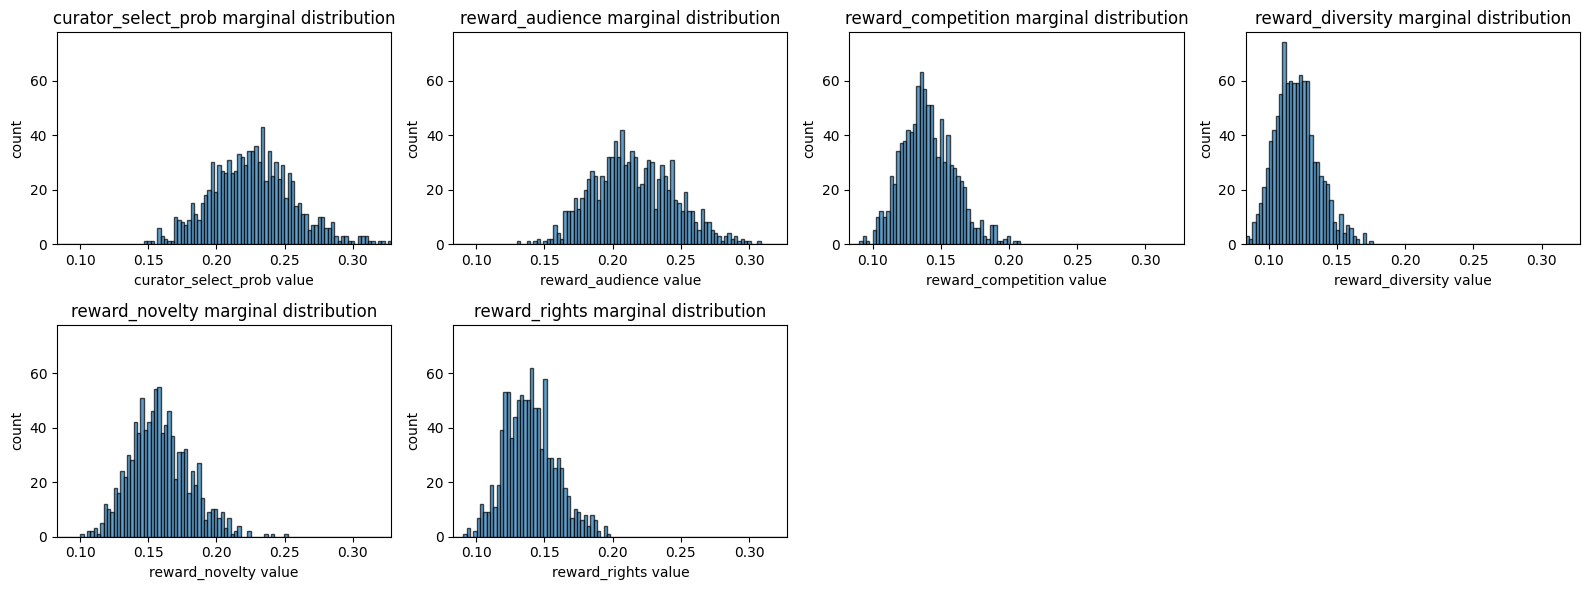

In [80]:
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100, context_features=context_f)
plt.show()

In [81]:
env.competitor_manager.update_competition_historical_data() # scrape future shwoings and add to historical data
env.get_available_movies(air_date, context)

[datetime.date(2025, 8, 9), datetime.date(2025, 8, 16), datetime.date(2025, 8, 23)]


Weeks for M6: 100%|██████████| 3/3 [00:00<00:00, 30247.38it/s]


In [82]:
def recommend_n_films(context, air_date, curator_model):
    # movies: list of movie IDs, X_cands: Mxd numpy array
    # Thompson‐Sampling selects one
    print('Getting candidate features...')
    context_f, _ = env.get_context_features(context)
    movies, X_cands = env.get_candidate_features_cts_cur(context, air_date, curator_model=curator_model)
    print('Done')
    top5_idx, top5_scores, w_tilde, _ = cts.score_candidates(context_f, X_cands, K=5)
    recommended = [movies[i] for i in top5_idx]

    for movie, score in zip(recommended, top5_scores):
        print(f"{movie}: score = {score:.3f}")

    return recommended, top5_idx, top5_scores, w_tilde, movies, X_cands

recommended, top5_idx, top5_scores, w_tilde, movies, X_cands  = recommend_n_films(context, air_date, curator_model)


Getting candidate features...


100%|██████████| 1172/1172 [00:46<00:00, 25.26it/s]

Done
31768: score = 0.603
754430: score = 0.598
331836: score = 0.597
291984: score = 0.595
21435: score = 0.592


In [83]:
print(f'hyperparams: ema_decay = {cts.ema_decay}')

hyperparams: ema_decay = 0.999


In [84]:
env.movie_catalog.loc[recommended]['processed_title'].to_list()

['Amy',
 'Pause',
 'Babysitting 2',
 'Ma vie avec John F. Donovan',
 'Les Bronzés 3 : Amis pour la vie']

In [85]:
env.movie_catalog.loc[recommended]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,start_rights,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown
catalog_id,,,,,,,,,,,,,,,,,,,,,
31768,Amy,None,False,2.0,Film,0.0,71,2025-07-19,NaT,NaT,...,2022-09-01,31768.0,2.0,1,6.067,True,False,True,26,0
754430,Pause,"Baptiste Gilliéron, Julia Faure, André Wilms, ...",False,99999999.0,Film,3.0,71,2016-03-18,2023-08-22,2022-01-11,...,2015-08-13,754430.0,99999999.0,1,0.000,True,False,True,4,0
331836,Babysitting 2,"Philippe Lacheau, Alice David, Vincent Desagna...",False,1.0,Film,0.0,71,2018-02-12,2019-01-19,2019-01-19,...,2023-09-15,331836.0,1.0,1,6.327,True,False,True,9,0
291984,Ma vie avec John F. Donovan,"Kit Harington, Natalie Portman, Susan Sarandon...",False,2.0,Film,0.0,71,2025-08-12,NaT,NaT,...,2022-09-30,291984.0,2.0,1,6.887,True,False,True,6,0
21435,Les bronzés 3 : amis pour la vie,"Thierry Lhermitte, Josiane Balasko, Michel Bla...",False,1.0,Film,0.0,71,2008-09-08,2022-07-02,2017-04-01,...,2023-11-01,21435.0,1.0,1,4.071,True,False,True,19,0


In [86]:
def show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands):
    eps = 1e-9  # threshold to consider "non-zero"
    for i, idx in enumerate(top5_idx):
        movie_id = movies[idx]
        x = X_cands[idx]
        total = top5_scores[i]
        print(f"\n🎬 {movie_id}: {env.movie_catalog.loc[movie_id]['title']}  (total score = {total:.3f}) (p = {sigmoid(total)})")
        print("  Breakdown:")

        # build list of (name, xi, wi, contribution)
        contribs = [
            (name, float(xi), float(wi), float(xi * wi))
            for name, xi, wi in zip(all_feature_names, x, w_tilde)
        ]
        # filter out negligible contributions
        nonzero = [t for t in contribs if abs(t[3]) > eps]
        # sort by absolute impact (change to key=lambda t: -t[3] if you want signed descending)
        nonzero.sort(key=lambda t: t[3], reverse=True)

        for name, xi, wi, contrib in nonzero:
            sign = "+" if contrib >= 0 else "-"
            print(f"    • {name:30s} {xi:6.3f} × {wi:6.3f} = {contrib:7.3f} ({sign})")

show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands)



🎬 31768: Amy  (total score = 0.603) (p = 0.6462648069919403)
  Breakdown:
    • reward_audience                 0.951 ×  0.196 =   0.187 (+)
    • reward_rights                   1.000 ×  0.143 =   0.143 (+)
    • reward_novelty                  0.750 ×  0.176 =   0.132 (+)
    • curator_select_prob             0.520 ×  0.200 =   0.104 (+)
    • reward_diversity                0.300 ×  0.126 =   0.038 (+)

🎬 754430: Pause  (total score = 0.598) (p = 0.6451198876798457)
  Breakdown:
    • reward_audience                 0.949 ×  0.196 =   0.186 (+)
    • reward_rights                   1.000 ×  0.143 =   0.143 (+)
    • reward_novelty                  0.750 ×  0.176 =   0.132 (+)
    • curator_select_prob             0.497 ×  0.200 =   0.099 (+)
    • reward_diversity                0.300 ×  0.126 =   0.038 (+)

🎬 331836: Babysitting 2  (total score = 0.597) (p = 0.6450685438436654)
  Breakdown:
    • reward_audience                 0.921 ×  0.196 =   0.181 (+)
    • curator_select_pro

In [87]:
recommended

['31768', '754430', '331836', '291984', '21435']

## Loop

In [88]:
import copy

cts_copy = copy.deepcopy(cts)

h_U: 0.03443383365198268, h_b: 0.054355054286953065
hyperparams: ema_decay = 0.999


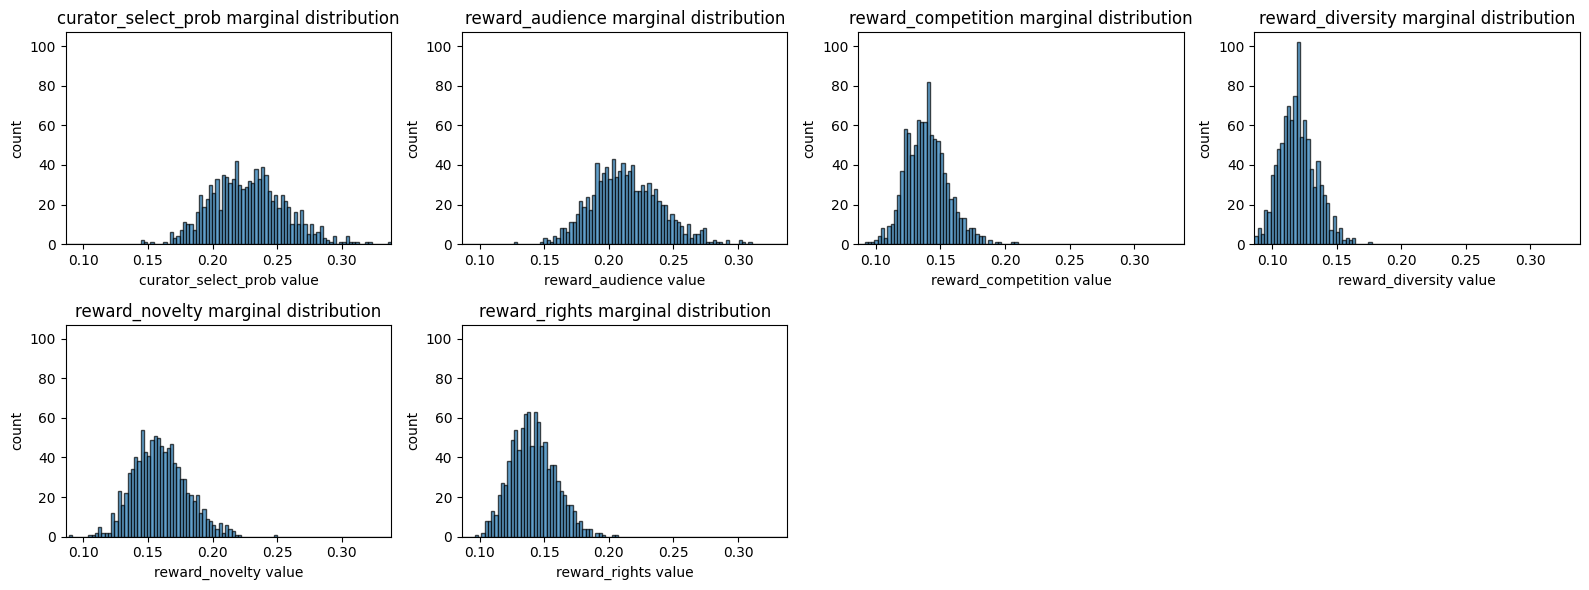

In [89]:
print(f'h_U: {cts_copy.h_U.mean()}, h_b: {cts_copy.h_b.mean()}')
print(f'hyperparams: ema_decay = {cts_copy.ema_decay}')
fig, axes, samples = marginal_weight_distribution_cts(cts_copy, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

Getting candidate features...


100%|██████████| 1162/1162 [00:46<00:00, 25.01it/s]


Done
1400817: score = 0.598
525452: score = 0.596
487297: score = 0.595
959098: score = 0.590
248507: score = 0.587

🎬 1400817: Mort sur terre battue  (total score = 0.598) (p = 0.6452383007738021)
  Breakdown:
    • curator_select_prob             0.998 ×  0.239 =   0.238 (+)
    • reward_audience                 0.953 ×  0.215 =   0.205 (+)
    • reward_novelty                  0.750 ×  0.162 =   0.121 (+)
    • reward_diversity                0.300 ×  0.111 =   0.033 (+)

🎬 525452: Orgueil et préjugés  (total score = 0.596) (p = 0.6447160141676298)
  Breakdown:
    • curator_select_prob             0.934 ×  0.239 =   0.223 (+)
    • reward_audience                 0.954 ×  0.215 =   0.206 (+)
    • reward_novelty                  0.750 ×  0.162 =   0.121 (+)
    • reward_diversity                0.300 ×  0.111 =   0.033 (+)
    • reward_rights                   0.100 ×  0.129 =   0.013 (+)

🎬 487297: Ce que veulent les hommes  (total score = 0.595) (p = 0.6445946661547304)
  Breakdo

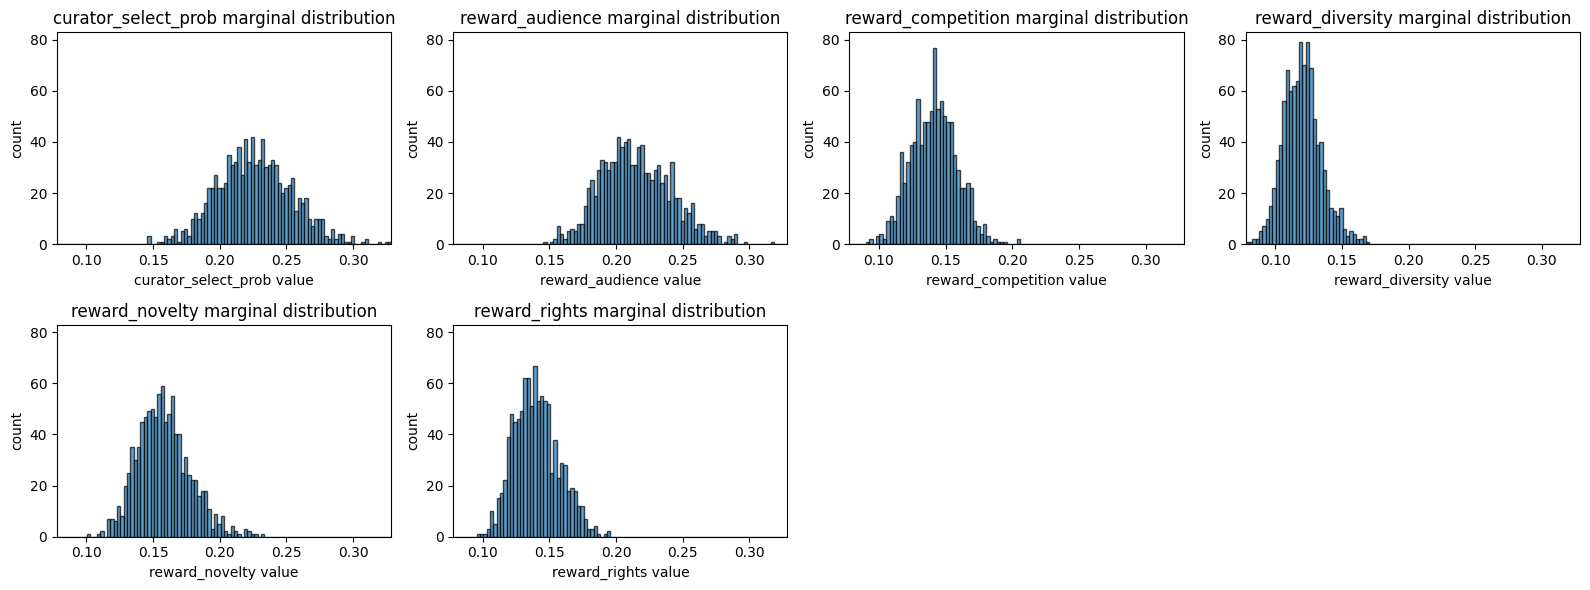

Type go when done analyzing


In [90]:
from IPython.display import clear_output
chosen_movie = '-1'


while chosen_movie == '-1':
    chosen_movie = input()
    if chosen_movie != '-1':
        chosen_idx = movies.index(chosen_movie)
    else:
        chosen_idx = -1
    
    for idx in top5_idx:
        x_i = X_cands[idx]                    # feature vector for this shown movie

        if idx == chosen_idx:
            r = 1                            # curator chose it
        else:
            r = 0                            # curator did *not* choose it

        cts_copy.update(context_f, x_i, r)                   # Bayesian update: A ← A + x xᵀ; b ← b + r·x
        param_std = np.sqrt(cts_copy.expl_scale / cts_copy.h_U)      # same shape as U
        print("Mean param std:", param_std.mean())
        print(f'h_U: {cts_copy.h_U.mean()}, h_b: {cts_copy.h_b.mean()}')
    fig, axes, samples = marginal_weight_distribution_cts(cts_copy, env, all_feature_names, num_samples=1000, show=False, bins=100)
    plt.show()
    print('Type go when done analyzing')
    status = input()
    if status == '':
        break
    if chosen_movie == '-1':
        available_movies = [movie for  movie in env.available_movies if movie not in recommended]
        env.available_movies= available_movies
        print(len(env.available_movies))
        clear_output(wait=True)
        recommended, top5_idx, top5_scores, w_tilde, movies, X_cands  = recommend_n_films(context, air_date, curator_model)
        show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands)

chosen_movie = '-1'

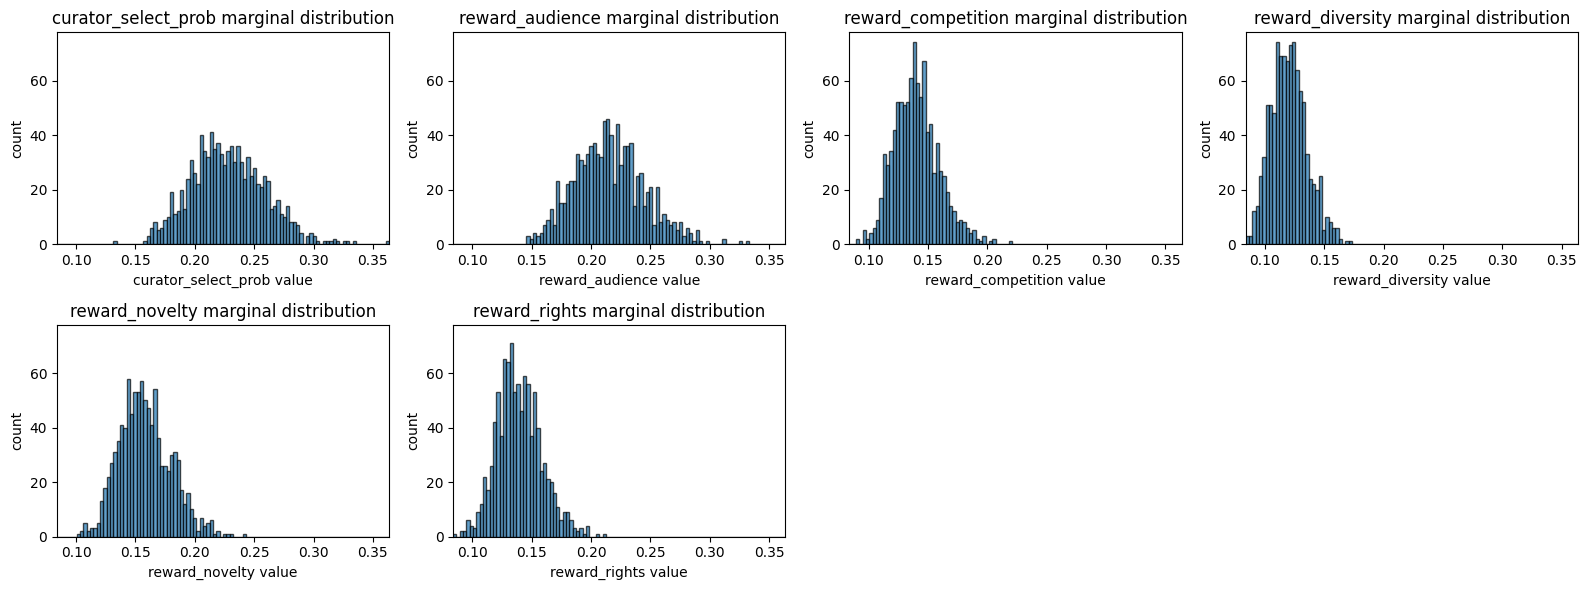

In [92]:
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100, context_features=context_f)
plt.show()

In [93]:
env.movie_catalog.loc[recommended]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,start_rights,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown
catalog_id,,,,,,,,,,,,,,,,,,,,,
1400817,Mort sur terre battue,"Yannick Noah, Florent Peyre, Roxanne Roux",False,3.0,Film,0.0,71,NaT,NaT,NaT,...,2025-04-14,1400817.0,3.0,1,0.000,True,False,True,0,0
525452,Orgueil et préjugés,"Matthew Mc Fadyen, Judi Dench, Donald Sutherla...",False,2.0,Film,0.0,71,2008-06-09,2008-06-09,NaT,...,2025-01-01,525452.0,2.0,1,6.300,True,False,True,7,0
487297,Ce que veulent les hommes,"Taraji P. Henson, Aldis Hodge, Josh Brener, Ri...",False,1.0,Film,1.0,71,2023-03-31,2023-03-31,NaT,...,2022-12-08,487297.0,2.0,1,6.217,True,False,True,6,0
959098,Le dernier jaguar,"Lumi Pollack, Emily Bett Rickards, Wayne Charl...",False,2.0,Film,0.0,71,NaT,NaT,NaT,...,2025-04-06,959098.0,2.0,1,6.684,True,False,True,1,0
248507,Supercondriaque,"Dany Boon, Kad Merad, Alice Pol, Judith El Zei...",False,1.0,Film,0.0,71,2016-04-11,2023-02-25,2016-10-08,...,2024-01-20,248507.0,1.0,1,5.505,True,False,True,11,0


## Save Thompson Sampling model

In [96]:
cts_copy.save(Path("models/ts_state.npz"))


In [97]:
ts = ContextualThompsonSampler.load(Path("models/ts_state.npz"))